In [1]:
from facet_ml.classification import cnn

from facet_ml.classification import cnn
import torch
from torch import nn
import numpy as np
from torchvision.models import resnet152
from pathlib import Path
import matplotlib.pyplot as plt


c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [2]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

data_folder = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\ProcessedData\Coco_v5"
dataloaders, datasizes = cnn.load_colloidal_datasets_coco(
    str(data_folder),
    num_workers=16,
    batch_size=20,
)

[[      0 1226692]
 [      1   84028]]
[[     0 979019]
 [     1 331701]]
[[     0 854550]
 [     1 456170]]
[[      0 1262745]
 [      1   47975]]
[[      0 1251303]
 [      1   59417]]
[[     0 905640]
 [     1 405080]]


In [3]:
dl = dataloaders["train"]
test_images,test_labels = next(iter(dl))

In [4]:
from facet_ml.classification import cnn
dir_path = Path(data_folder)
dataset = cnn.CocoColloidalDataset(str(dir_path / "train"),str(dir_path / "train" / "_annotations.coco.json"))
print(len(dataset))
print(type(dataset[1][0]))
np.shape(dataset[1][0]), np.shape(dataset[1][1])

[[      0 1226692]
 [      1   84028]]
[[     0 979019]
 [     1 331701]]
[[     0 854550]
 [     1 456170]]
[[      0 1262745]
 [      1   47975]]
80
<class 'PIL.Image.Image'>


((256, 256, 3), torch.Size([256, 256]))

In [5]:
# # images.shape,labels.shapetes
# print(dl.dataset.dataset[0])
# ii = 4
# test_img, test_label = test_images[ii,0,:,:], test_labels[ii,:,:].to("cpu")

# figs,axes = plt.subplots(ncols=2)
# axes[0].imshow(test_img)
# axes[1].imshow(test_label)

In [6]:
import time
from tempfile import TemporaryDirectory
import os

model = cnn.SegUNet(3)
model.to(device=device)

## Get model trianing information
criterion = nn.BCEWithLogitsLoss()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr=0.5, 
                            momentum=0.9, 
                            weight_decay=0.0001)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = lr_scheduler
# Num epochs
num_epochs = 3

dataset_sizes = datasizes

# Model loop
    
since = time.time()

# Create a temporary directory to save training checkpoints
loss_dict = {"train": [], "test": []}
accuracy_dict = {"train": [], "test": []}
with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = torch.tensor(inputs)
                # labels = torch.tensor(labels)
                # print(inputs.shape, labels.shape)
                inputs = inputs.to(device)

                labels = labels.to(device).unsqueeze(1).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs) > 0.5
                    # print("Outputs and Preds", outputs.shape, preds.shape)
                    # print(list(zip(outputs, preds)))
                    loss = criterion(outputs, labels)
                    # print(loss)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).cpu()

            loss_dict[phase].append(epoch_loss)
            accuracy_dict[phase].append(epoch_acc)

            print(
                f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}, ({running_corrects}/{dataset_sizes[phase]})"
            )

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(
        f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))


Epoch 0/2
----------
train Loss: 0.5917 Acc: 54037.5750, (4323006/80)
test Loss: 0.4679 Acc: 53923.5750, (2156943/40)

Epoch 1/2
----------
train Loss: 0.4833 Acc: 54037.5750, (4323006/80)
test Loss: 0.5096 Acc: 53923.5750, (2156943/40)

Epoch 2/2
----------
train Loss: 0.4958 Acc: 54037.5750, (4323006/80)
test Loss: 0.4797 Acc: 53923.5750, (2156943/40)

Training complete in 6m 34s
Best val Acc: 0.000000


tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(-2.0064) tensor(-1.9674)


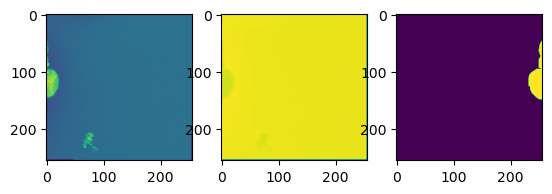

In [14]:
print(torch.max(labels.data), torch.min(labels.data))
print(torch.min(preds),torch.max(preds))
patch_to_use = 6
sample_input = inputs[patch_to_use,0,:,:].to("cpu")
sample_output = outputs[patch_to_use,0,:,:].to("cpu")
sample_label = labels[patch_to_use,0,:,:].to("cpu")
# print(outputs[0,0,:,:]) # torch.Size([2, 1, 256, 256])
print(torch.min(sample_output),torch.max(sample_output))
torch.sum(preds == labels.data)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3)

axes[0].imshow(sample_input)
axes[1].imshow(sample_output)
axes[2].imshow(sample_label)

In [8]:
outputs
_, preds = torch.max(outputs, 1)
print("Outputs and Preds", outputs.shape, preds.shape)
# print(list(zip(outputs, preds)))
loss = criterion(outputs, labels)
print(loss)
print(loss)
print(loss.item() * inputs.size(0))
print(torch.sum(preds == labels.data))
print(running_loss)
print(running_loss / dataset_sizes["test"])

Outputs and Preds torch.Size([20, 1, 256, 256]) torch.Size([20, 256, 256])
tensor(0.3142, device='cuda:0')
tensor(0.3142, device='cuda:0')
6.284034848213196
tensor(23772080, device='cuda:0')
19.187178015708923
0.4796794503927231


In [9]:
# Load model
# model = cnn.get_model(2, resnet152(weights="DEFAULT"))
# model = cnn.get_binary_model(2, resnet152(weights="DEFAULT"))
model = cnn.SegUNet(3)
model.to(device=device)

## Get model trianing information
criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr=0.5, 
                            momentum=0.9, 
                            weight_decay=0.0001)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model, loss_dict, accuracy_dict = cnn.train_model_coco(
    model,
    criterion,
    optimizer,
    lr_scheduler,
    num_epochs= 0,#50,
    dataloaders=dataloaders,
    dataset_sizes=datasizes,
)


Training complete in 0m 0s
Best val Acc: 0.000000


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Encoder
        self.encoder1 = self._conv_block(in_channels, 64)
        self.encoder2 = self._conv_block(64, 128)
        self.encoder3 = self._conv_block(128, 256)
        self.encoder4 = self._conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self._conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = self._upconv_block(1024, 512)
        self.decoder4 = self._conv_block(1024, 512)
        self.upconv3 = self._upconv_block(512, 256)
        self.decoder3 = self._conv_block(512, 256)
        self.upconv2 = self._upconv_block(256, 128)
        self.decoder2 = self._conv_block(256, 128)
        self.upconv1 = self._upconv_block(128, 64)
        self.decoder1 = self._conv_block(128, 64)
        
        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def _upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out = self.out_conv(dec1)
        return out

# Instantiate the model
model = UNet(in_channels=3, out_channels=1)  # RGB input, binary output
model =  cnn.SegUNet(3)

In [11]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device).float()  # BCEWithLogitsLoss expects float type masks
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))  # Add channel dimension for masks
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
num_epochs = 0  # Adjust as needed
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, dataloaders["train"], criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

# Save the model
torch.save(model.state_dict(), 'unet_model.pth')
